In [79]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from scipy.optimize import minimize, curve_fit

In [2]:
import sys
sys.path.append("../") # go to parent dir

#### Exercise 1

Given
$$\begin{equation}
\begin{split}
0 &=& -E[Y] + \beta_0 + \beta_1 E[X] \\
0 &=& -E[XY] + \beta_0 E[X] + \beta_1 E[X^2]
\end{split}
\end{equation}$$
we have
$$\beta_0 = E[Y] - \beta_1 E[X]$$
and then
$$0 = -E[XY] + (E[Y] - \beta_1 E[X]) E[X] + \beta_1 E[X^2],$$
from which follows
$$\beta_1 = \frac{E[XY] - E[X]E[Y]}{E[X^2] - E^2[X]} = \frac{\mathrm{Cov}[X, Y]}{\mathrm{Var}[X]} = \frac{\sigma_{XY}}{\sigma^2_X}$$
and
$$\beta_0 = E[Y] - \frac{\sigma_{XY}}{\sigma^2_X} E[X].$$

#### Exercise 2

The hedging equation:
$$F_{20}P_{20}\mathrm{DUR}_{20} \Delta y_{20} + F_{10}P_{10}\mathrm{DUR}_{10} \Delta y_{10} + F_{30}P_{30}\mathrm{DUR}_{30} \Delta y_{30} = 0,$$
or by rearranging the terms:
$$\Delta y_{20} = -\frac{F_{10}P_{10}\mathrm{DUR}_{10}}{F_{20}P_{20}\mathrm{DUR}_{20}} \Delta y_{10} - \frac{F_{30}P_{30}\mathrm{DUR}_{30}}{F_{20}P_{20}\mathrm{DUR}_{20}} \Delta y_{30}.$$
The regression yields
$$\Delta y_{20} = \hat{\beta}_1 \Delta y_{10} + \hat{\beta}_2 \Delta y_{30}.$$
Both equations are satisfied by setting
$$
\begin{equation}
\begin{split}
F_{10} &=& -\hat{\beta}_1 F_{20} \frac{P_{20} \mathrm{DUR}_{20}}{P_{10} \mathrm{DUR}_{10}} \\
F_{30} &=& -\hat{\beta}_2 F_{20} \frac{P_{20} \mathrm{DUR}_{20}}{P_{30} \mathrm{DUR}_{30}}
\end{split}
\end{equation}
$$

#### Exercise 3

In [21]:
data = pd.read_csv('../data/ZeroPrices.txt', sep='\\s+')
data.head()

,maturity,price
0,0.25,98.8073
1,0.88,94.6419
2,1.52,91.1392
3,2.15,88.0357
4,2.79,84.9174


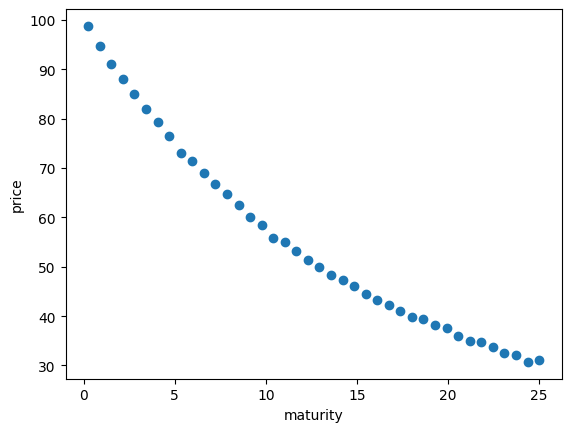

In [51]:
fig, ax = plt.subplots()
ax.plot(data['maturity'], data['price'], 'o');
ax.set_xlabel('maturity');
ax.set_ylabel('price');

In [30]:
def nelson_siegel_forward(T, theta):
    return theta[0] + (theta[1] + theta[2] * T) * np.exp(-theta[3] * T)

In [31]:
def nelson_siegel_yield(T, theta):
    return theta[0] + (theta[1] + theta[2] / theta[3]) * (1 - np.exp(-theta[3] * T) / theta[3] / T) - theta[2] / theta[3] * np.exp(-theta[3] * T)

In [42]:
def bond_price(T, theta):
    return 100 * np.exp(-nelson_siegel_yield(T, theta) * T)

In [43]:
def obj_fun(theta):
    return np.sum((bond_price(data['maturity'], theta) - data['price']) ** 2)

In [56]:
start = np.array([0, 0, 0, 1])
lower = np.array([-100, -100, -100, 0.0001])
upper = np.array([100, 100, 100, 100])
%time fit = minimize(obj_fun, start, method='L-BFGS-B', bounds=list(zip(lower, upper)))
fit

CPU times: user 1.91 s, sys: 2.16 ms, total: 1.92 s
Wall time: 1.91 s


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4.447595507505501
        x: [ 3.095e-02  3.111e-02 -7.762e-04  2.501e-02]
      nit: 154
      jac: [ 2.562e+02 -1.031e+03 -4.745e+04 -1.539e+03]
     nfev: 1305
     njev: 261
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

(a) The estimates are:

In [57]:
fit.x

array([ 0.03094535,  0.03111466, -0.00077623,  0.02501429])

(b)

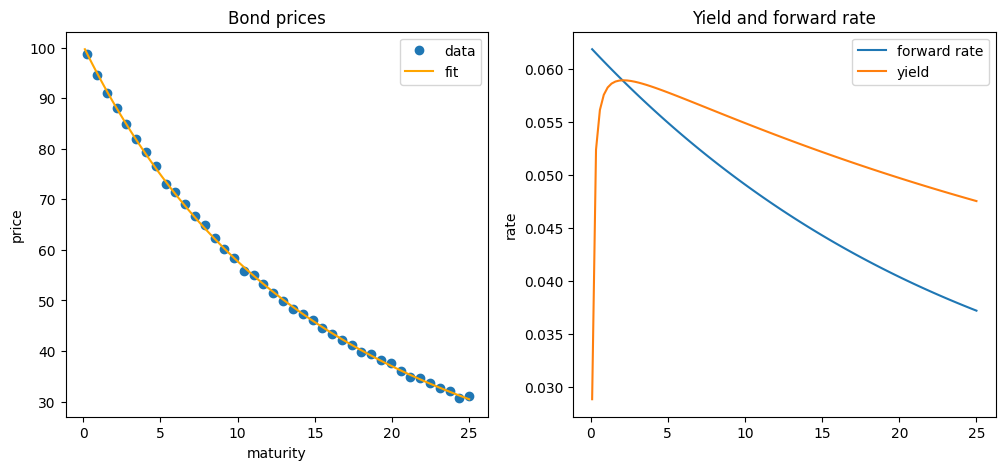

In [63]:
xs = np.linspace(0.1, 25, 100)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(data['maturity'], data['price'], 'o', label='data');
axs[0].plot(xs, bond_price(xs, fit.x), color='orange', label='fit');
axs[0].set_xlabel('maturity');
axs[0].set_ylabel('price');
axs[0].set_title('Bond prices');
axs[0].legend();

axs[1].plot(xs, nelson_siegel_forward(xs, fit.x), label='forward rate');
axs[1].plot(xs, nelson_siegel_yield(xs, fit.x), label='yield');
axs[0].set_xlabel('maturity');
axs[1].set_ylabel('rate');
axs[1].set_title('Yield and forward rate');
axs[1].legend();

#### Exercise 4

We check if the estimate of the rate from non-linear regression converges to the expectated value below.

In [84]:
def bond_price(T, r):
    return np.exp(-r * T)

In [140]:
rng = np.random.default_rng(seed=12345)

n = 10
samples = 10_000
r = 0.06
sigma_noise = 0.1
T = stats.uniform.rvs(size=(samples, n), loc=1, scale=15, random_state=rng)
P = bond_price(T, r) + stats.norm.rvs(size=(samples, n), scale=sigma_noise, random_state=rng)

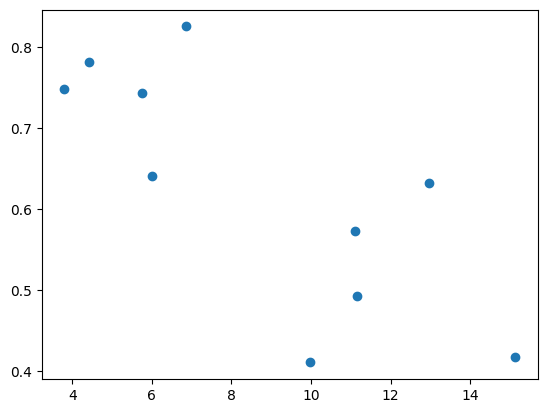

In [141]:
fig, ax = plt.subplots()
ax.scatter(T[0], P[0]);

In [142]:
estimates = np.fromiter((curve_fit(bond_price, T[i], P[i], p0=[0.01])[0][0] for i in range(samples)), float)

In [143]:
np.mean(estimates)

0.06027557555033627

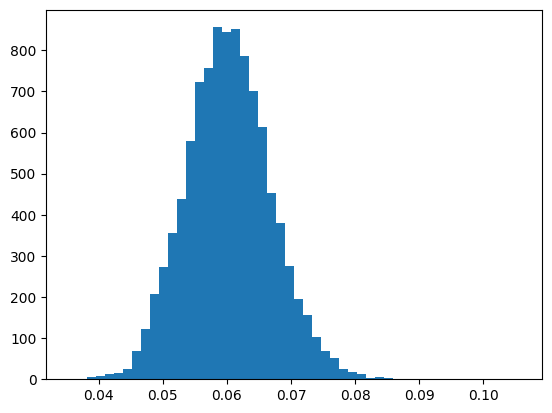

In [144]:
fig, ax = plt.subplots()
ax.hist(estimates, bins=50);